In [82]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch import mps
import cv2 as cv
from sklearn.cluster import KMeans
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [121]:
#setting
size = (300,300)
path = './processed/'
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
path_list = sorted(glob.glob('./processed/*.jpg')) # for the style mean
def get_image(path, img_transform, size = (300,300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t()) 
    return m

def denormalize_img1(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = inp.transpose((2,0,1))
    return inp
def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        layer_features = []
        for layer_number, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
        return layer_features
def compute_mean(path_list,encoder,sample_num):
    sample = get_image(path_list[0],img_transform)
    sample = encoder(sample)
    style_features =[]
    for i,feature in enumerate(sample):
        style_features.append(torch.zeros_like(get_gram(feature)))
    n=0
    for i in range(sample_num):
        n+=1
        idx = np.random.randint(0,len(path_list))
        style_img = get_image(path_list[idx],img_transform)
        style_feature = encoder(style_img)
        for index, feature in enumerate(style_feature):
            _,c,h,w  = feature.size()
            gram = get_gram(feature)
            style_features[index] = ((style_features[index]*((n-1)/n)) + (1/n)*gram)

    return style_features
def tranfer(encoer,content_feature,style_features,isReopt=False):
    global n_epoch
    global generated_img
    global optimizer
    global style_weight
    global content_weight
    for epoch in range(n_epochs):
        generated_features = encoder(generated_img)
        content_loss = torch.mean((content_feature[-1] - generated_features[-1])**2)
        style_loss = 0
        for gf, sf in zip(generated_features, style_features):
            _, c, h, w = gf.size()
            gram_gf = get_gram(gf)
            gram_sf = get_gram(sf)
            style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w)
        loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        loss.backward(
        )
def viz(output,original):
    output = output.detach().cpu().squeeze()
    output= denormalize_img(output)
    original = original.detach().cpu().squeeze()
    original = denormalize_img(original)
    merged= np.hstack((original,output))
    plt.title('original,result')
    plt.imshow(merged)
def kmeans(path):

    global device
    sample =  Image.open(path)
    sample = sample.resize(size, Image.LANCZOS)
    sample = img_transform(sample) # 3 300 400 (channel, height,width)
    sample= sample.transpose(0,2)
    original_shape = sample.shape
    print(sample.shape)
    kmeans = KMeans(n_clusters=8)
    flattened_img = torch.reshape(sample,(-1,3)) # 300*400 X 3
    kmeans.fit(flattened_img)
    zipped_label = kmeans.predict(flattened_img)
    flattened_img = torch.tensor(kmeans.cluster_centers_[zipped_label],dtype=torch.float32)
    sample = torch.reshape(flattened_img,original_shape)
    sample = sample.transpose(0,2) #이게 최종 불러온 이미지
    print(sample.shape)
    vutils.save_image(sample,'./temp.jpg')

<h3>style mean</h3>

In [96]:
c.shape

torch.Size([1, 3, 300, 300])

In [95]:
c = get_image('content3.jpeg',img_transform)

In [33]:
sample_num = 1000
n_epochs = 500
path_list = sorted(glob.glob(path+'*.jpg'))
encoder = FeatureExtractor().to(device)
for p in encoder.parameters():
    p.requires_grad=False

/Users/seominjae/styleTransfer/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/seominjae/styleTransfer/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
style_features= compute_mean(path_list,encoder,sample_num)

In [ ]:
#for compute the mean of style
style_features = []
sample = get_image(path_list[0],img_transform)
sample = encoder(sample)
for i in sample:
    temp = get_gram(i)
    style_features.append(torch.zeros_like(temp))
n=0
sample_list=[]
for i in range(sample_num):
    n+=1
    k = np.random.randint(0,len(path_list))
    sample_list.append(k)
    temp = get_image(path_list[k],img_transform)
    temp = encoder(temp)
    for idx,gram in enumerate(temp):
        gram = get_gram(gram)
        style_features[idx]= style_features[idx]*((n-1)/n)+(1/n)*gram

In [62]:
generated_img.dtype

torch.float32

In [122]:
def kmeans(path):

    global device
    sample =  Image.open(path)
    sample = sample.resize(size, Image.LANCZOS)
    sample = img_transform(sample) # 3 300 400 (channel, height,width)
    sample= sample.transpose(0,2)
    original_shape = sample.shape
    print(sample.shape)
    kmeans = KMeans(n_clusters=8)
    flattened_img = torch.reshape(sample,(-1,3)) # 300*400 X 3
    kmeans.fit(flattened_img)
    zipped_label = kmeans.predict(flattened_img)
    flattened_img = torch.tensor(kmeans.cluster_centers_[zipped_label],dtype=torch.float32)
    sample = torch.reshape(flattened_img,original_shape)
    sample = sample.transpose(0,2) #이게 최종 불러온 이미지
    print(sample.shape)
    sample = torch.tensor(denormalize_img1(sample))
    print(sample.shape)
    vutils.save_image(sample,'temp.jpg')

In [123]:
kmeans('content3.jpeg')

torch.Size([300, 300, 3])


/Users/seominjae/styleTransfer/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


torch.Size([3, 300, 300])
torch.Size([300, 3, 300])


TypeError: Cannot handle this data type: (1, 1, 300), |u1

In [35]:
content_weight, style_weight = 1,100
n_epochs = 2000

In [74]:
optimizer.param_groups[0]['differentiable']

False

In [77]:
content_img.requires_grad

False

/Users/seominjae/styleTransfer/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


tensor(317.2455, device='mps:0', grad_fn=<AddBackward0>)
tensor(441.6857, device='mps:0', grad_fn=<AddBackward0>)
tensor(591.0256, device='mps:0', grad_fn=<AddBackward0>)
tensor(591.7817, device='mps:0', grad_fn=<AddBackward0>)
0
tensor(317.2455, device='mps:0', grad_fn=<AddBackward0>)
tensor(441.6857, device='mps:0', grad_fn=<AddBackward0>)
tensor(591.0256, device='mps:0', grad_fn=<AddBackward0>)
tensor(591.7817, device='mps:0', grad_fn=<AddBackward0>)
tensor(317.2455, device='mps:0', grad_fn=<AddBackward0>)
tensor(441.6857, device='mps:0', grad_fn=<AddBackward0>)
tensor(591.0256, device='mps:0', grad_fn=<AddBackward0>)
tensor(591.7817, device='mps:0', grad_fn=<AddBackward0>)
tensor(317.2455, device='mps:0', grad_fn=<AddBackward0>)
tensor(441.6857, device='mps:0', grad_fn=<AddBackward0>)
tensor(591.0256, device='mps:0', grad_fn=<AddBackward0>)
tensor(591.7817, device='mps:0', grad_fn=<AddBackward0>)
tensor(317.2455, device='mps:0', grad_fn=<AddBackward0>)
tensor(441.6857, device='mps:

KeyboardInterrupt: 

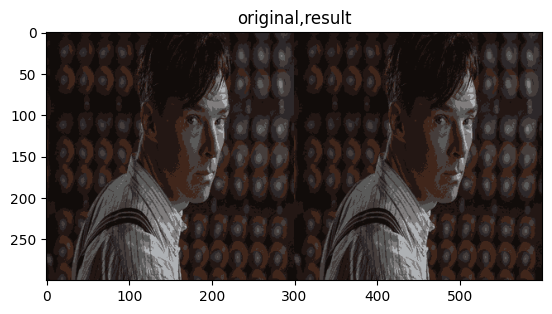

In [79]:
#now optimize the content for the style
content_img = kmeans('content3.jpeg')
content_img.requires_grad=True
#generated_img = content_img.clone()    # or nn.Parameter(torch.FloatTensor(content_img.size()))
generated_img = content_img.detach().clone()
generated_img.requires_grad = True
optimizer = torch.optim.Adam([generated_img], lr=0.1, betas=[0.5, 0.999])
content_features = encoder(content_img)
for epoch in range(n_epochs):
    generated_features = encoder(generated_img)
    
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)  #MSE
    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        style_loss += torch.mean((gram_gf - sf)**2)  / (c * h * w)
        print(style_loss)

    
    loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 0:
        print(epoch)
        viz(generated_img,content_img)

In [48]:
denormalize_img(generated_img.detach().cpu().squeeze)

ValueError: axes don't match array

In [111]:
test = np.array([[1,2,3]])

In [114]:
test.shape

(1, 3)

(3, 1)

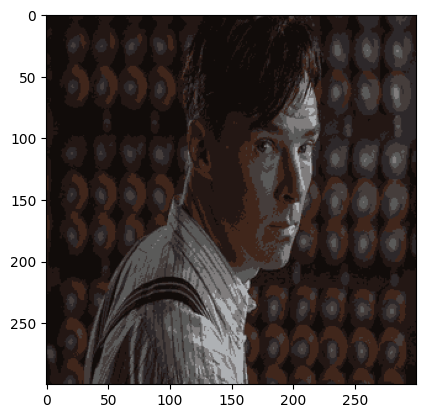

In [51]:
plt.imshow(denormalize_img(content_img.detach().cpu().squeeze()))

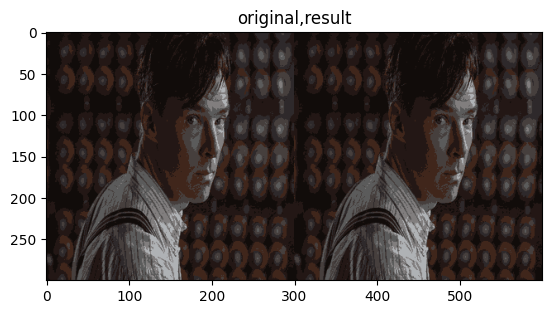

In [16]:
viz(generated_img,content_img)

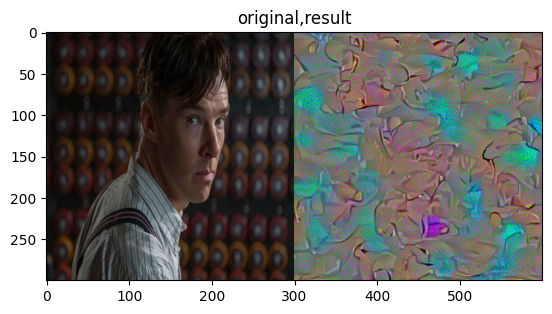

In [58]:
viz(generated_img,content_img)

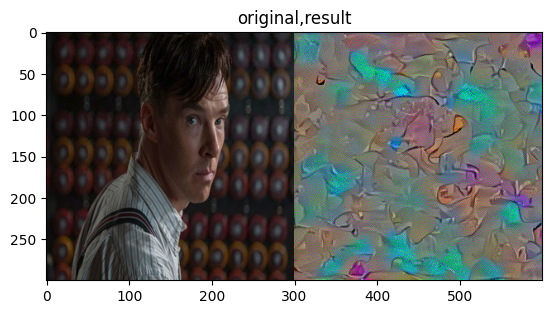

In [55]:
viz(generated_img,content_img)

<h3>vanila NST</h3>

In [177]:
encoder=FeatureExtractor().to(device)
for p in encoder.parameters():
    p.requires_grad=False

/Users/seominjae/styleTransfer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/seominjae/styleTransfer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [190]:
content_img = get_image('content2.jpg',img_transform)
style_img=get_image('style.jpg',img_transform)
content_img.requires_grad=False
style_img.requires_grad=False
generated_img = content_img.clone()
generated_img.requires_grad = True
content_features = encoder(content_img)
style_features = encoder(style_img)
optimizer = torch.optim.Adam([generated_img], lr=0.002, betas=[0.5, 0.999])

In [191]:
for epoch in range(n_epochs):
    generated_features = encoder(generated_img)
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)  
    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w)
    loss = content_weight * content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

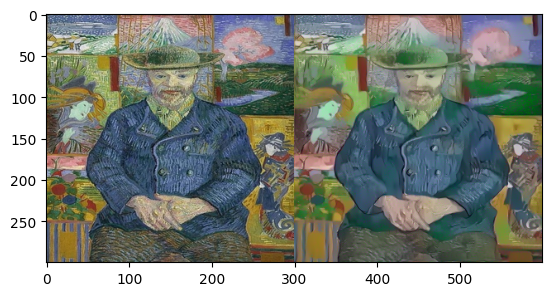

In [99]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
ori = content_img.detach().cpu().squeeze()
ori = denormalize_img(ori)
merged = np.hstack((ori,inp))
plt.imshow(merged) #원본, transfered

In [30]:
generated_img.shape

torch.Size([1, 3, 300, 300])

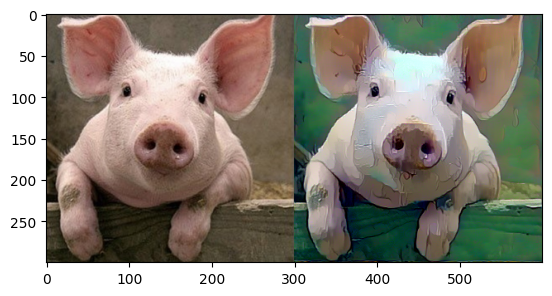

In [192]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
ori = content_img.detach().cpu().squeeze()
ori = denormalize_img(ori)
merged = np.hstack((ori,inp))
plt.imshow(merged) #원본, transfered

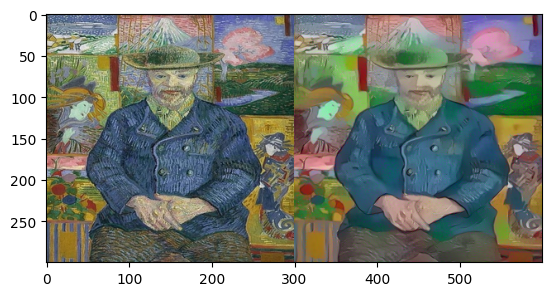

In [115]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
ori = content_img.detach().cpu().squeeze()
ori = denormalize_img(ori)
merged = np.hstack((ori,inp))
plt.imshow(merged) #원본, transfered